# Машинное обучение, ФКН ВШЭ

## Практическое задание 5. Решающие деревья

### Общая информация
Дата выдачи: 18.11.2022

Мягий дедлайн: 23:59MSK 30.11.2022

Жестокий дедлайн: 23:59MSK 06.12.2022

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплиментацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-05-trees-Username.ipynb
* Модуль hw5code.py
* Ссылки на посылки в Яндекс.Контесте для обеих задач

В контест https://contest.yandex.ru/contest/43413/problems/ нужно отправить файл hw5code.py с реализованными функциями и классами.

Username — ваша фамилия и имя на латинице именно в таком порядке

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже:

__Оценка:__ 11

In [169]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
from collections import Counter
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [ ]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0., )
]

In [ ]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

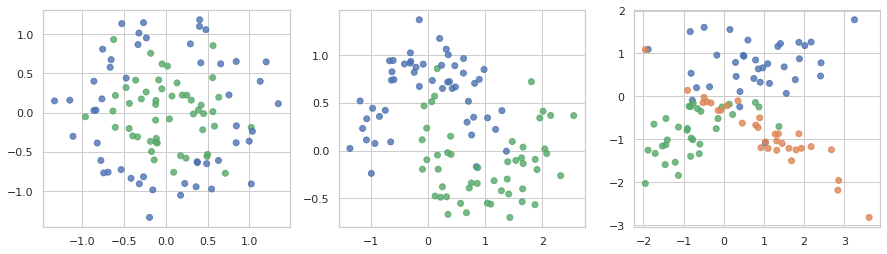

In [ ]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [ ]:
def plot_surface(clf, X, y, ax):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

In [ ]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)

plot_surface(lr, X, y)

Circles train accuracy: 1.000, test accuracy: 0.800
Moons   train accuracy: 1.000, test accuracy: 0.771
3 Class train accuracy: 1.000, test accuracy: 0.743


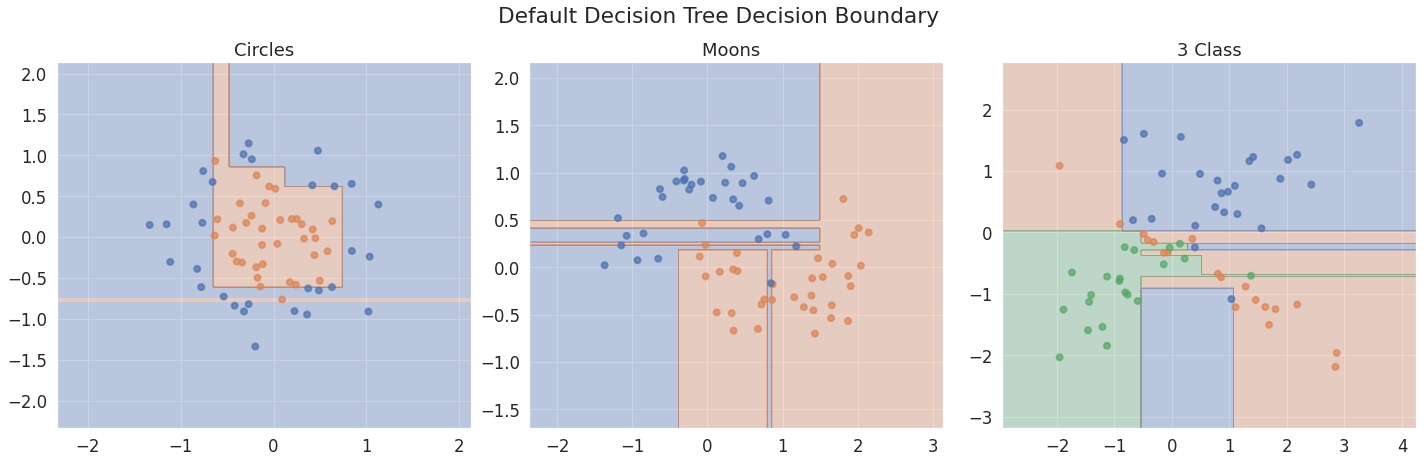

In [ ]:
datasets_names = {0: "Circles",
                  1: "Moons  ",
                  2: "3 Class"}
decision_tree = DecisionTreeClassifier(random_state=69)
sns.set(font_scale=1.5)
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
fig.suptitle("Default Decision Tree Decision Boundary")
for i, (X, y) in enumerate(datasets):
    ax = axes[i]
    ax.set_title(f"{datasets_names[i]}")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=69)
    decision_tree.fit(X_train, y_train)
    plot_surface(decision_tree, X_train, y_train, ax=ax)
    print(f"{datasets_names[i]} train accuracy: {accuracy_score(y_train, decision_tree.predict(X_train)):.3f}, test accuracy: {accuracy_score(y_test, decision_tree.predict(X_test)):.3f}")

__Ответ:__ Как видно по узким областям классификации для одного объекта, и тест accuracy=1, деревья максимально переобучились.

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

max_depth=4, min_samples_leaf=1 Circles train accuracy: 0.985, test  accuracy: 0.800
max_depth=4, min_samples_leaf=1 Moons   train accuracy: 0.985, test  accuracy: 0.771
max_depth=4, min_samples_leaf=1 3 Class train accuracy: 0.923, test  accuracy: 0.743
max_depth=4, min_samples_leaf=2 Circles train accuracy: 0.954, test  accuracy: 0.857
max_depth=4, min_samples_leaf=2 Moons   train accuracy: 0.954, test  accuracy: 0.886
max_depth=4, min_samples_leaf=2 3 Class train accuracy: 0.923, test  accuracy: 0.743
max_depth=4, min_samples_leaf=3 Circles train accuracy: 0.954, test  accuracy: 0.857
max_depth=4, min_samples_leaf=3 Moons   train accuracy: 0.954, test  accuracy: 0.857
max_depth=4, min_samples_leaf=3 3 Class train accuracy: 0.908, test  accuracy: 0.771
max_depth=4, min_samples_leaf=4 Circles train accuracy: 0.938, test  accuracy: 0.857
max_depth=4, min_samples_leaf=4 Moons   train accuracy: 0.938, test  accuracy: 0.829
max_depth=4, min_samples_leaf=4 3 Class train accuracy: 0.892, te

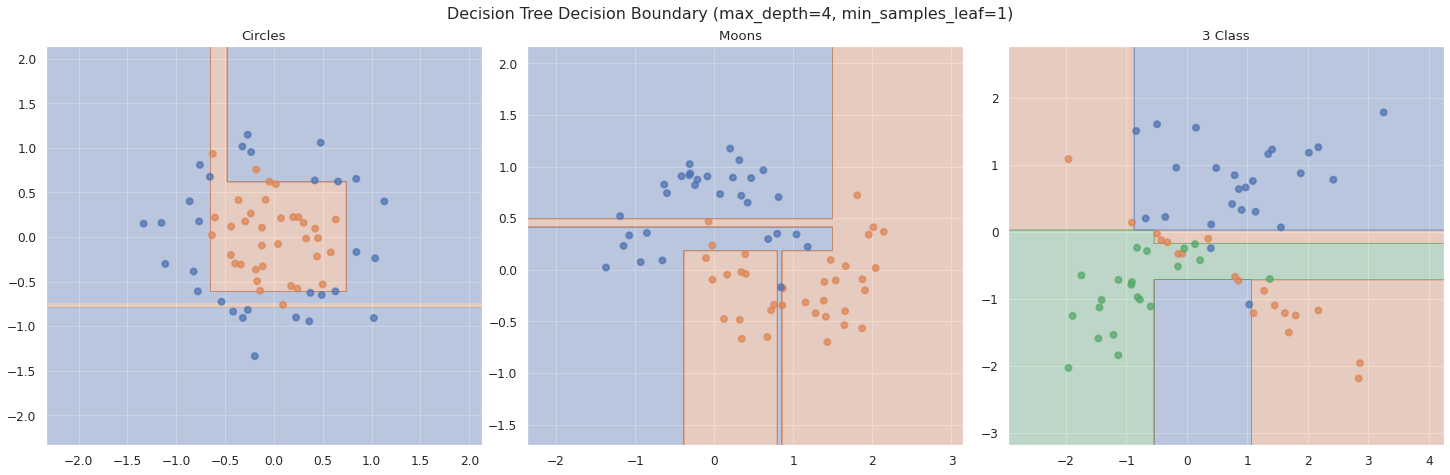

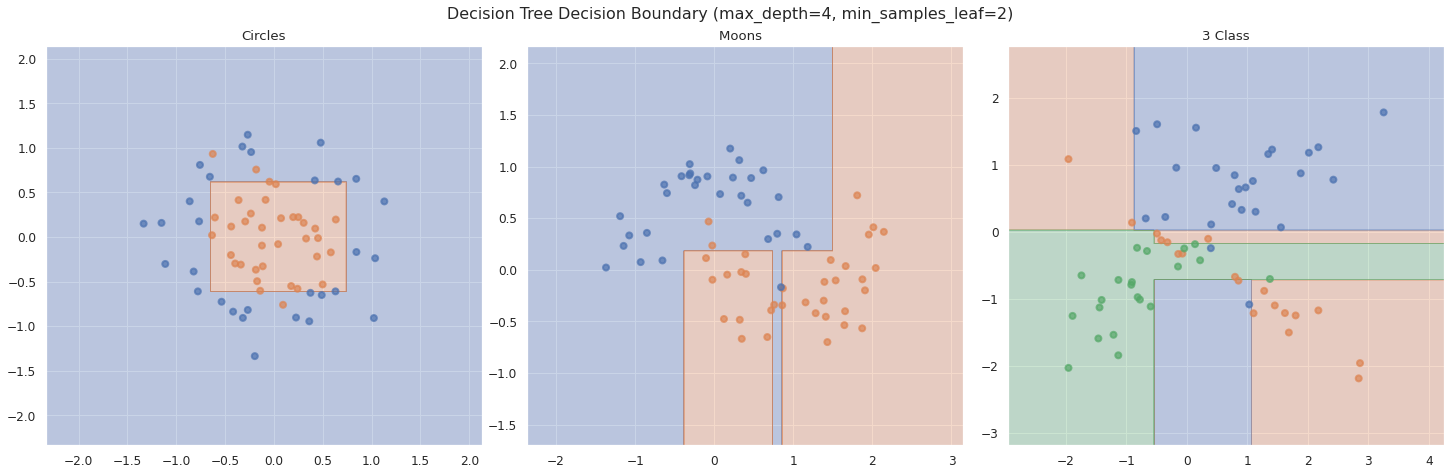

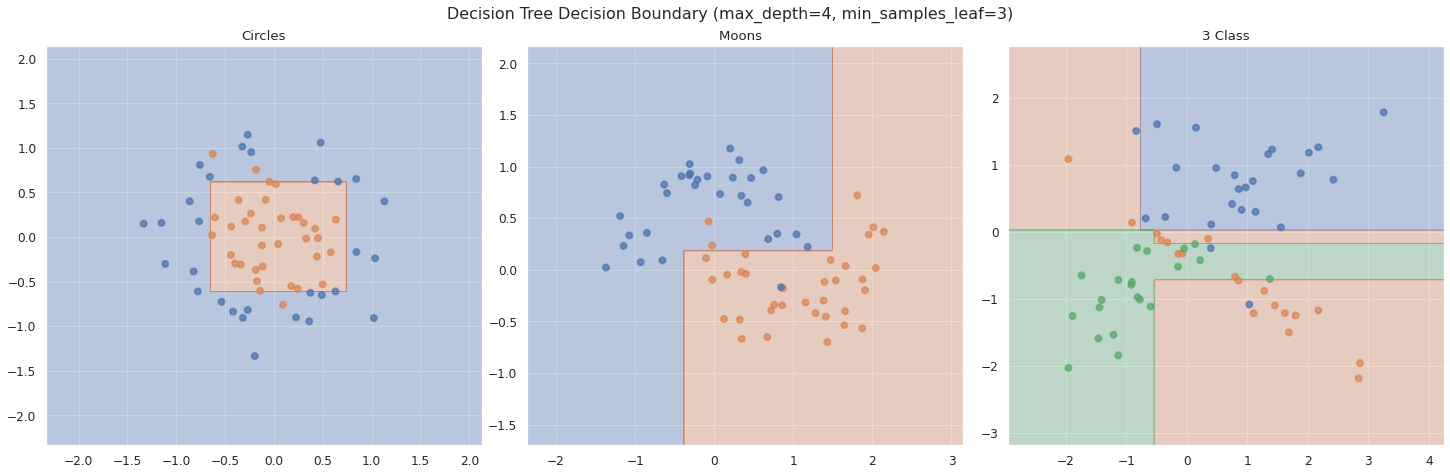

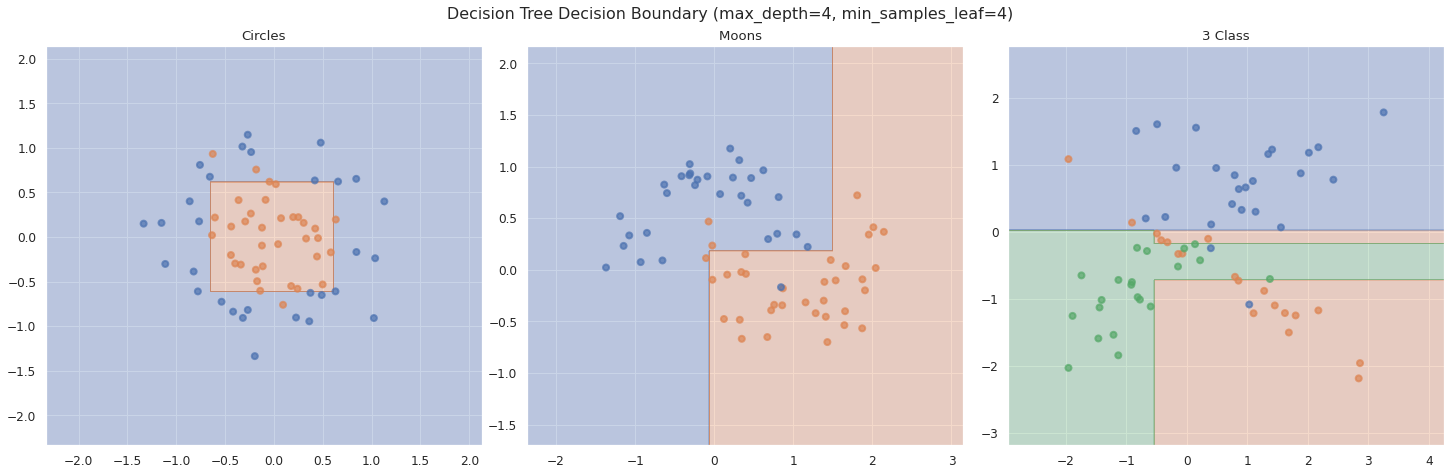

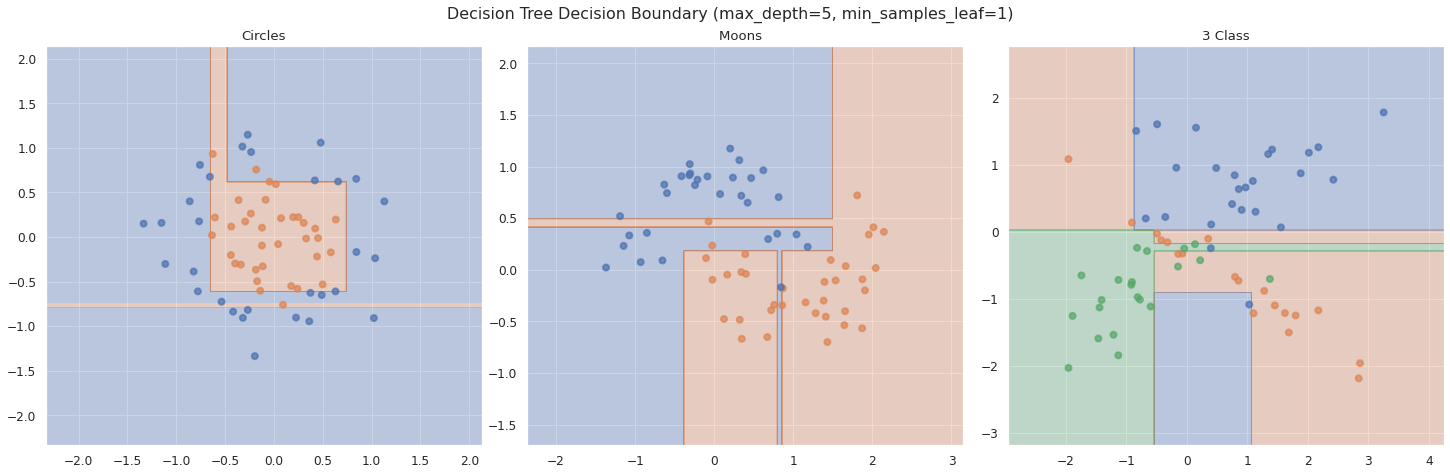

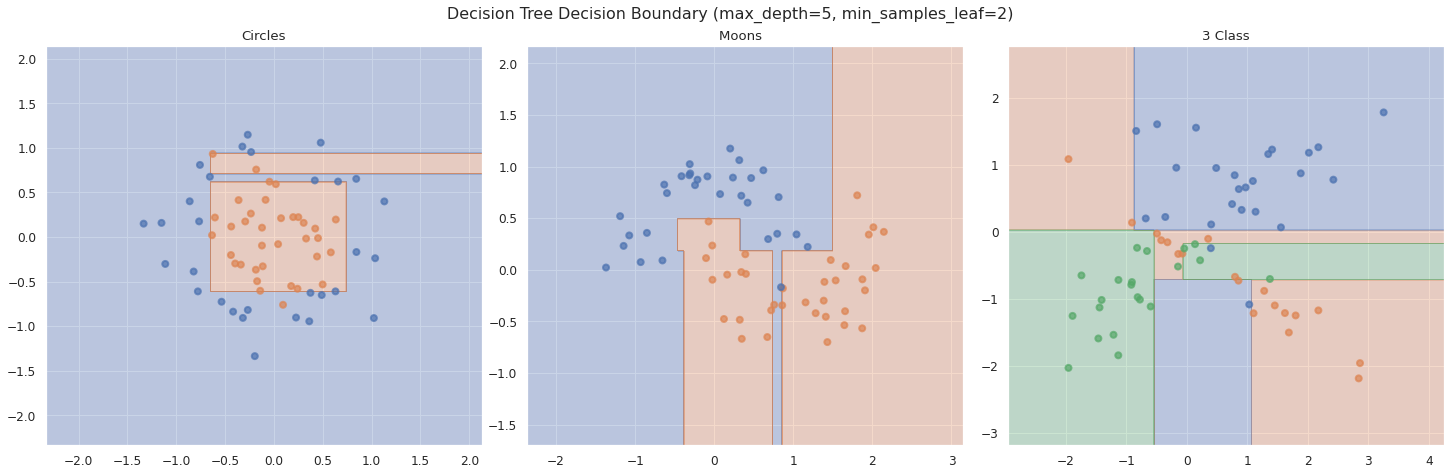

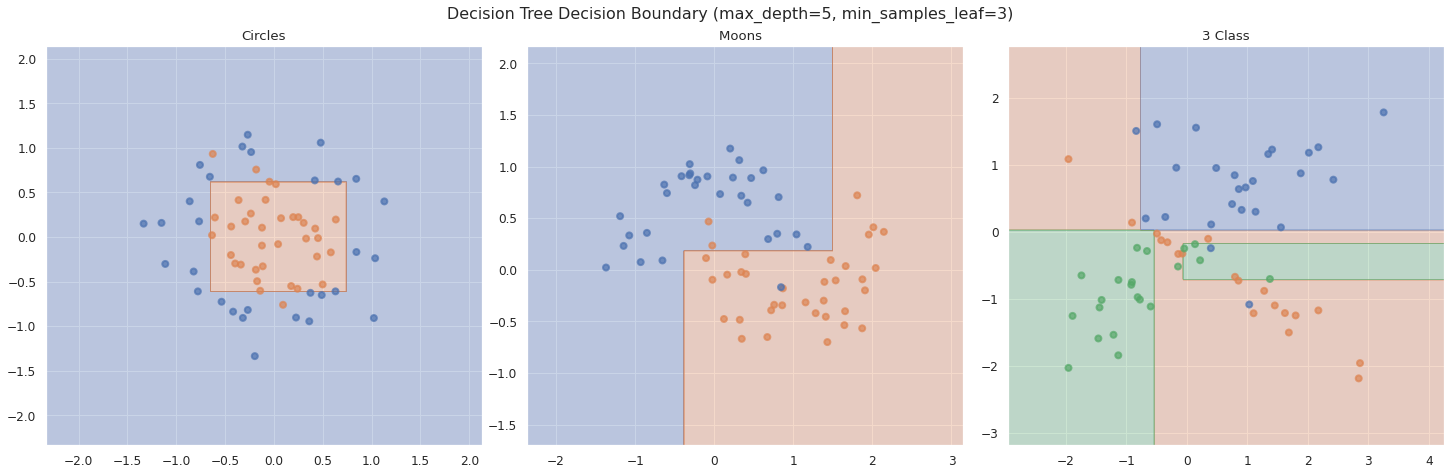

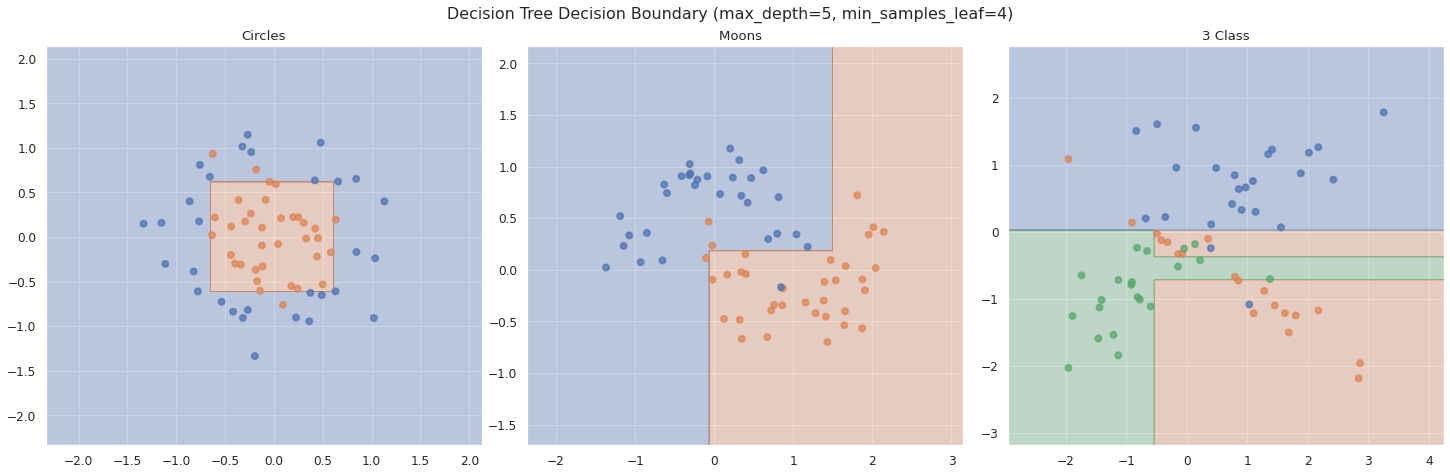

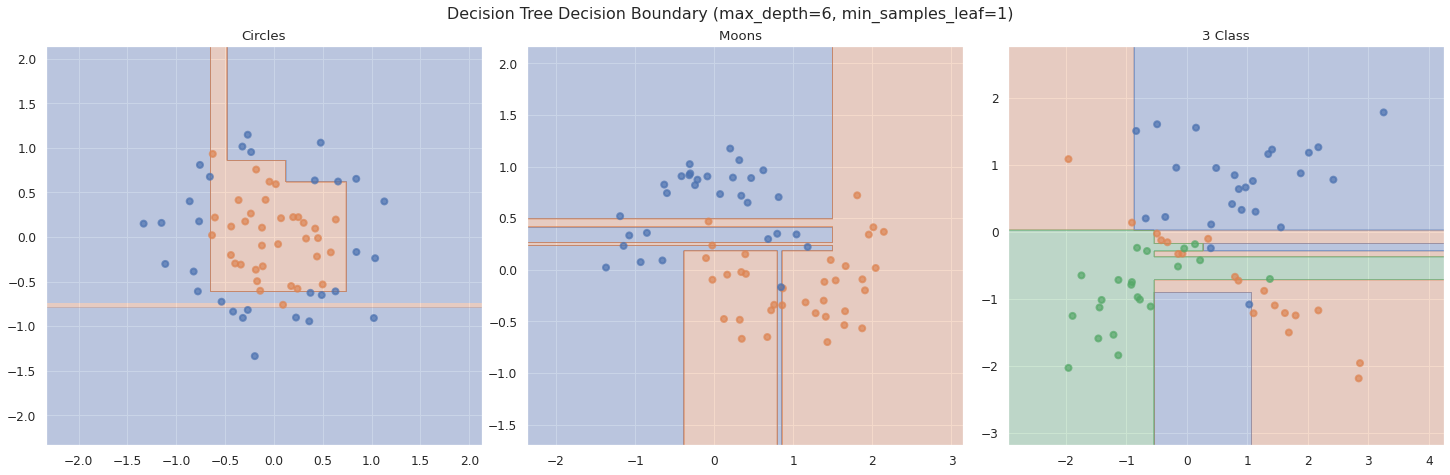

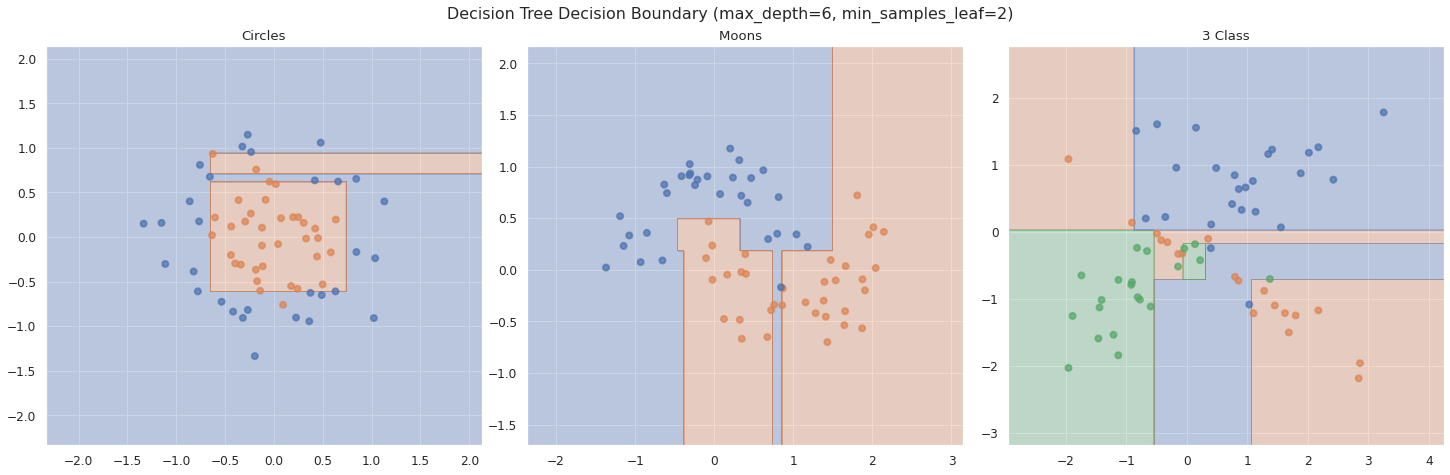

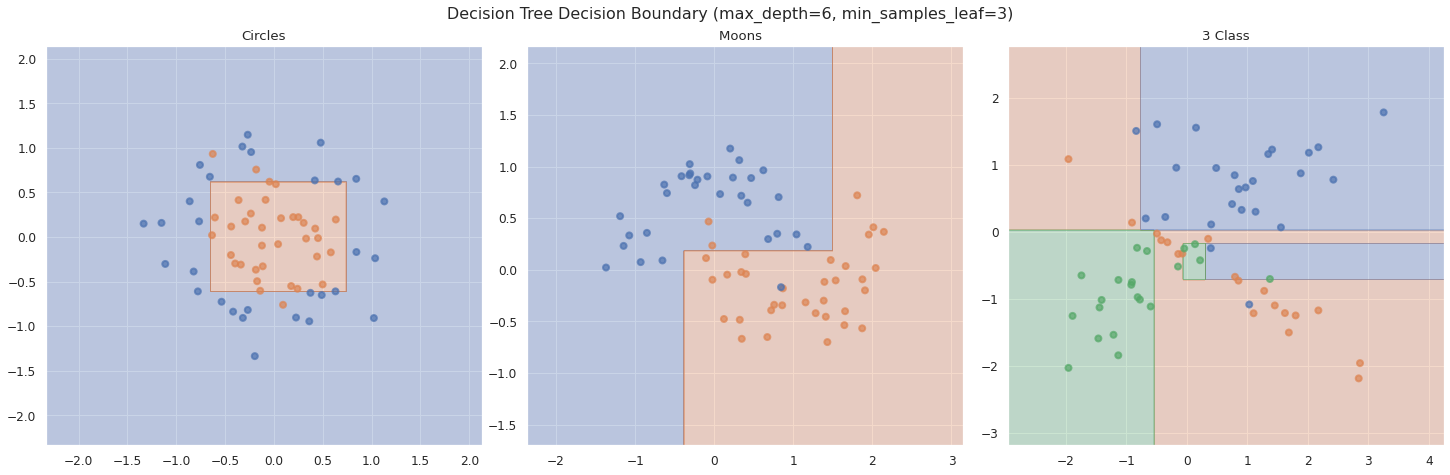

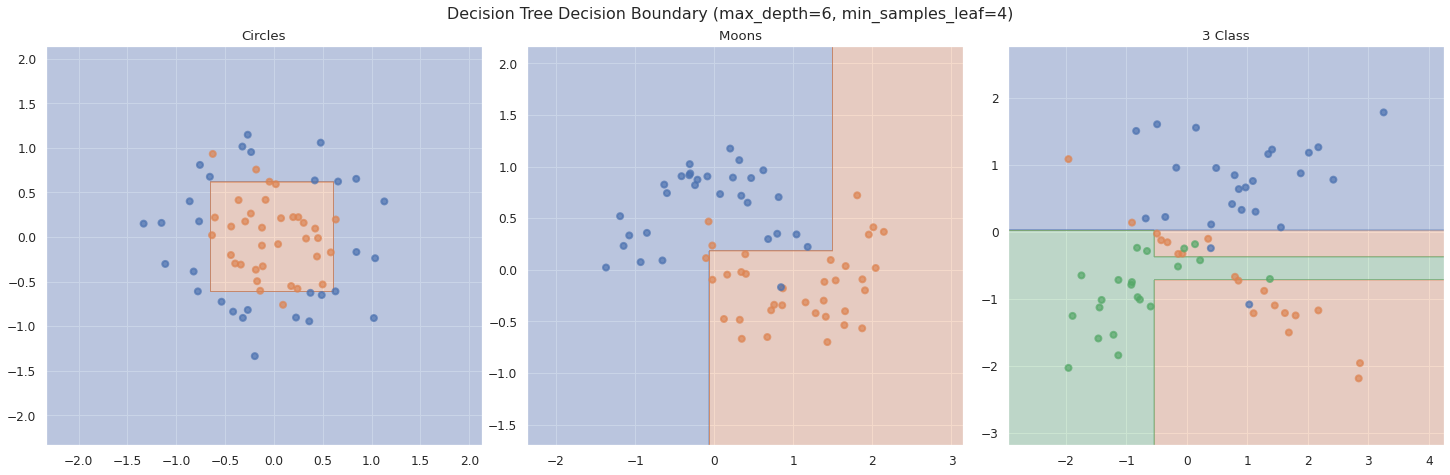

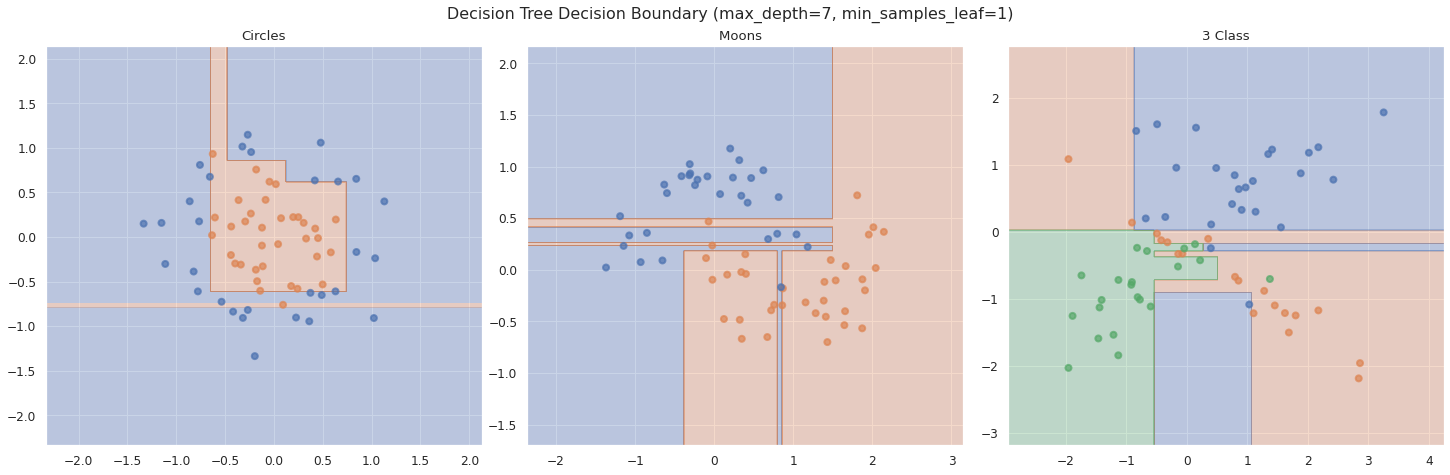

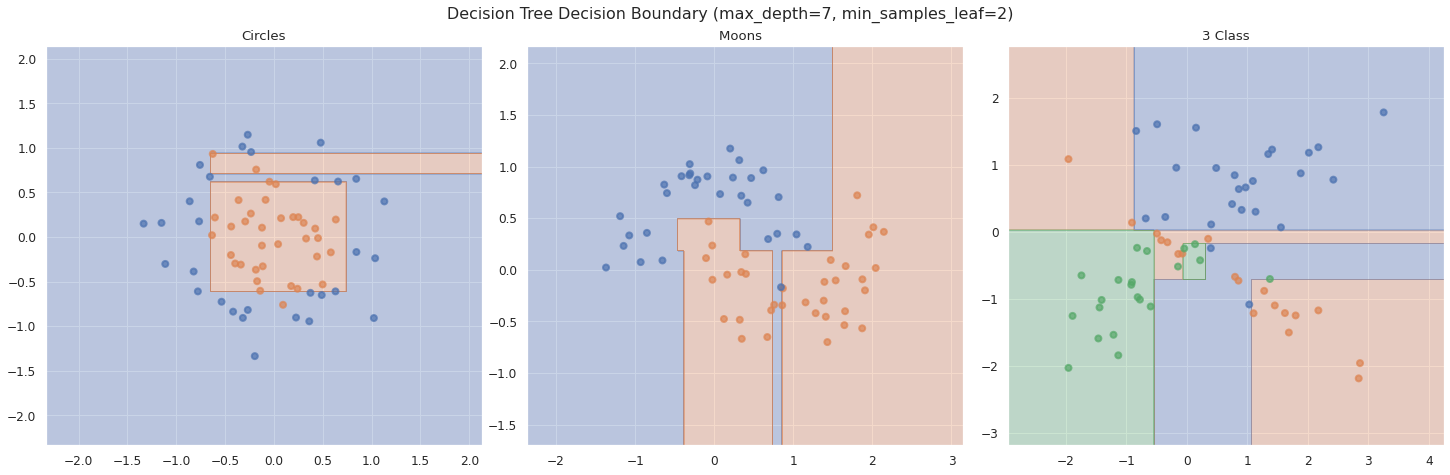

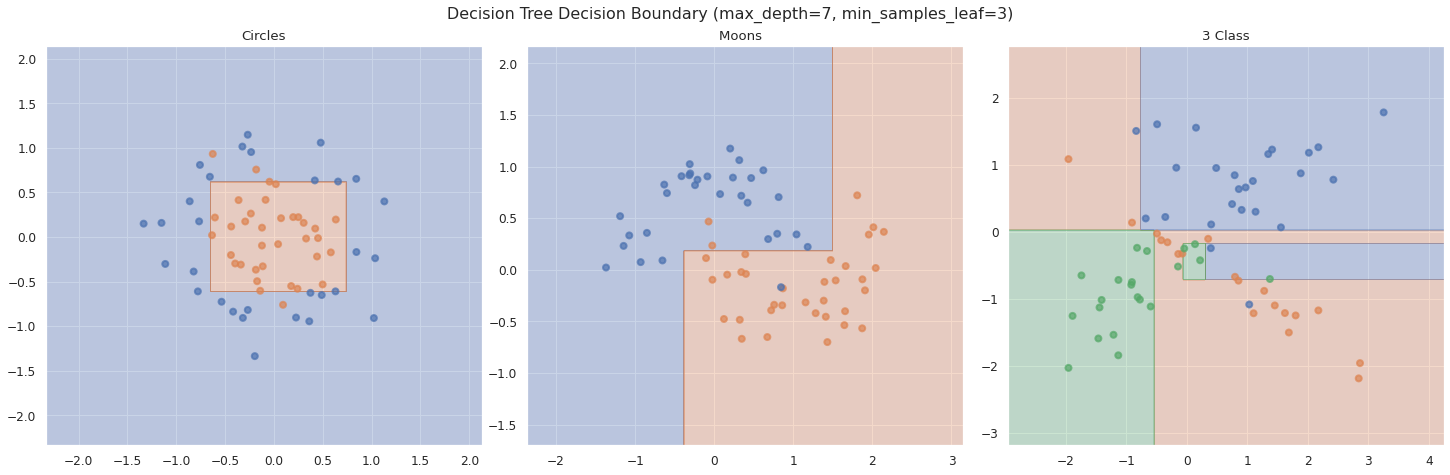

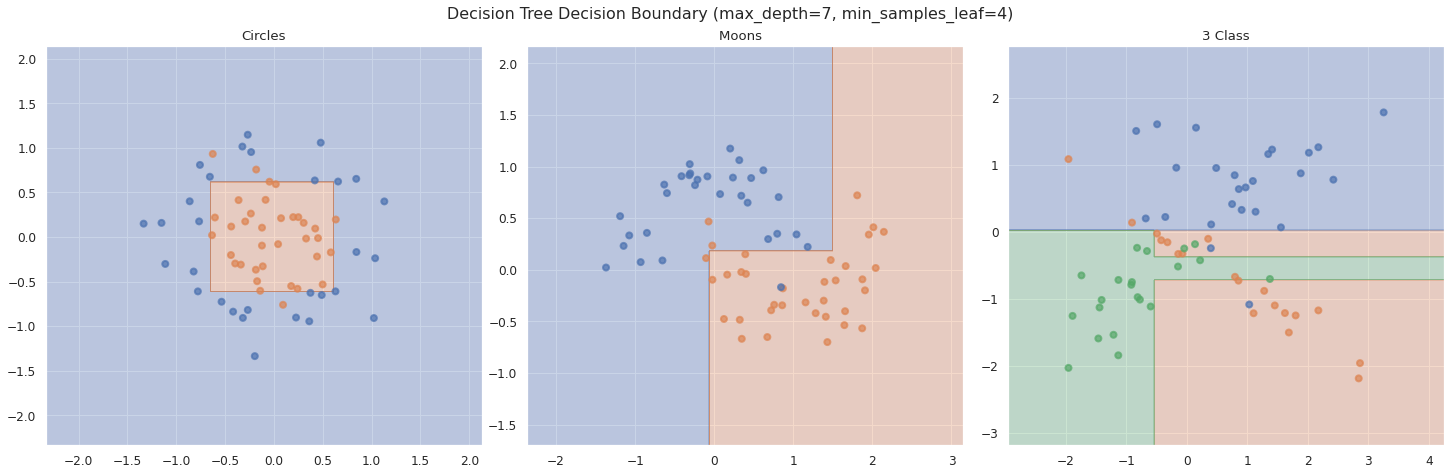

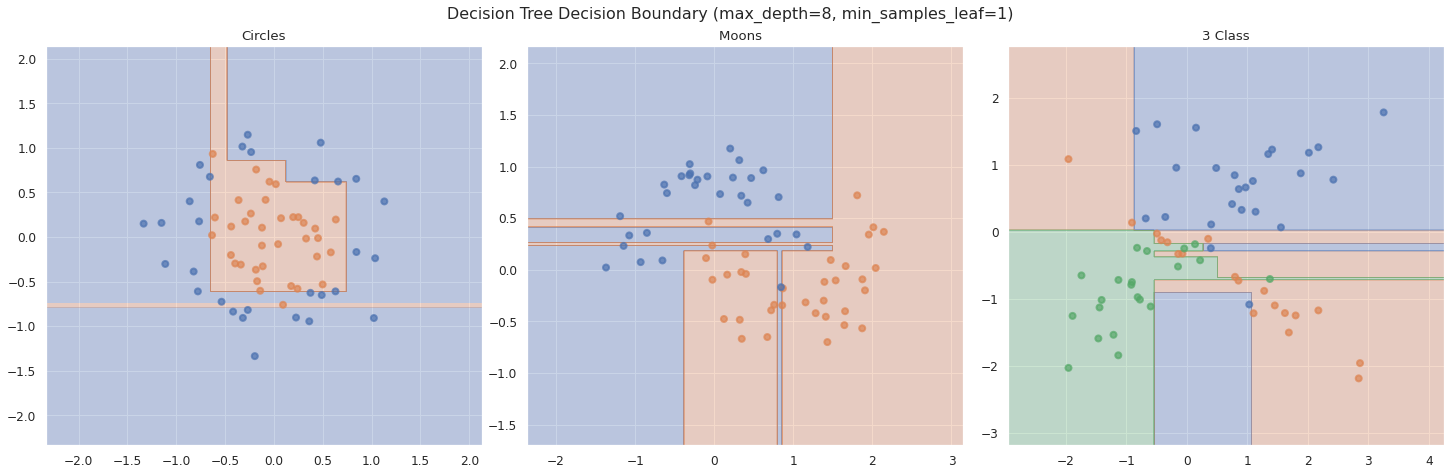

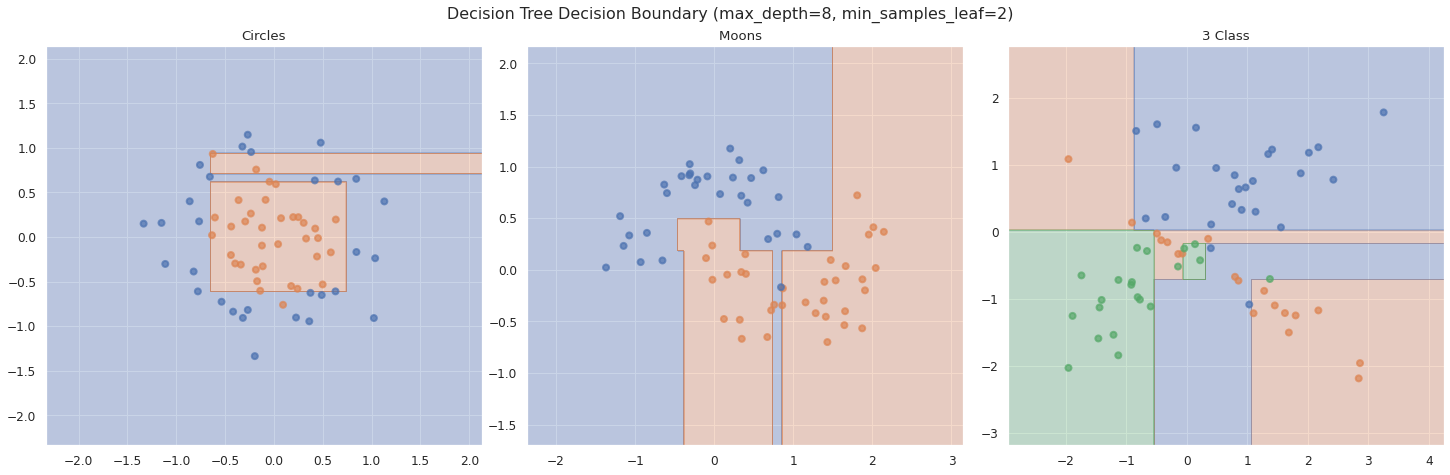

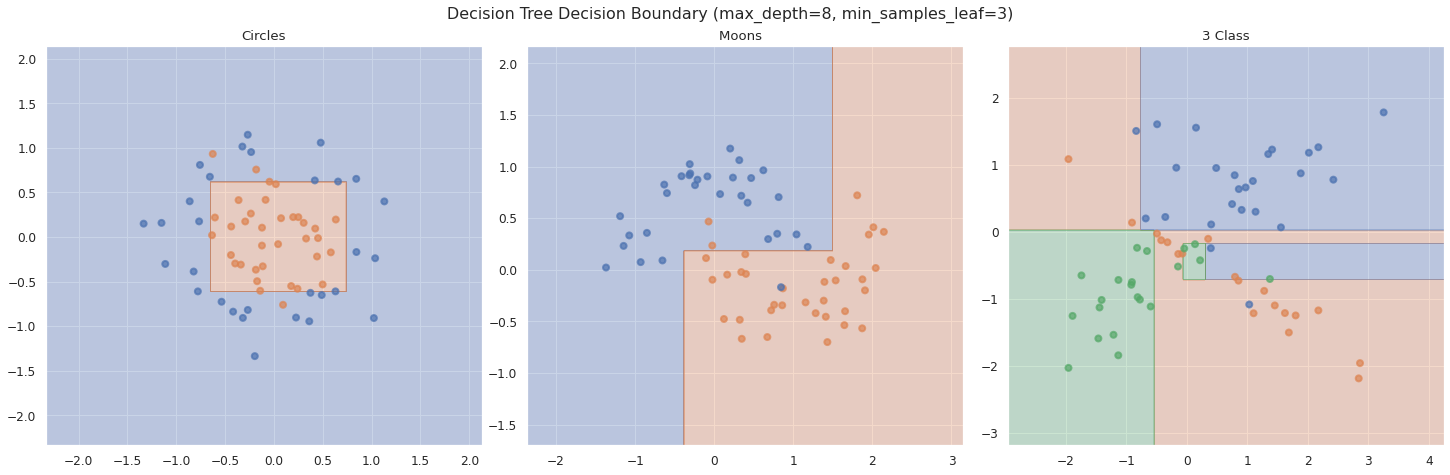

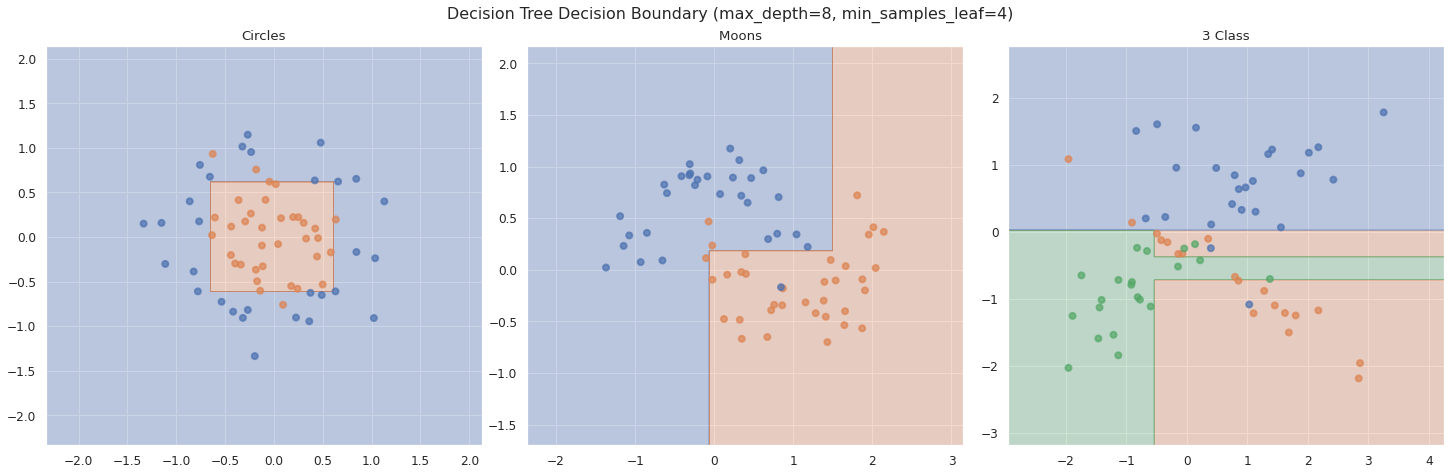

In [ ]:
max_depth_list = np.arange(4, 8 + 1, 1)
min_samples_leaf_list = np.arange(1, 4 + 1, 1)
accuracies = {'train': {i: pd.DataFrame(0, index=max_depth_list, columns=min_samples_leaf_list, dtype='float64') for i in range(3)},
              'test': {i: pd.DataFrame(0, index=max_depth_list, columns=min_samples_leaf_list, dtype='float64') for i in range(3)}
              }

sns.set(font_scale=1.1)

for max_depth in max_depth_list:
    for min_samples_leaf in min_samples_leaf_list:
        fig, axes = plt.subplots(1, 3, figsize=(21, 7))
        fig.suptitle(f"Decision Tree Decision Boundary (max_depth={max_depth}, min_samples_leaf={min_samples_leaf})")
        decision_tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=69)
        for i, (X, y) in enumerate(datasets):
            ax = axes[i]
            ax.set_title(f"{datasets_names[i]}")
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=69)
            decision_tree.fit(X_train, y_train)
            plot_surface(decision_tree, X_train, y_train, ax=ax)
            print(f"max_depth={max_depth}, min_samples_leaf={min_samples_leaf} {datasets_names[i]} train accuracy: {accuracy_score(y_train, decision_tree.predict(X_train)):.3f}, "
                                                                                                   f"test  accuracy: {accuracy_score(y_test, decision_tree.predict(X_test)):.3f}")
            accuracies['train'][i].loc[max_depth, min_samples_leaf] = accuracy_score(y_train, decision_tree.predict(X_train))
            accuracies['test'][i].loc[max_depth, min_samples_leaf] = accuracy_score(y_test, decision_tree.predict(X_test))

In [ ]:
for t in ['train', 'test']:
    for i in range(3):
        print(f"{datasets_names[i]} {t} accuracies:")
        print(accuracies[t][i])

Circles train accuracies:
          1         2         3         4
4  0.984615  0.953846  0.953846  0.938462
5  0.984615  0.984615  0.953846  0.938462
6  1.000000  0.984615  0.953846  0.938462
7  1.000000  0.984615  0.953846  0.938462
8  1.000000  0.984615  0.953846  0.938462
Moons   train accuracies:
          1         2         3         4
4  0.984615  0.953846  0.953846  0.938462
5  0.984615  0.984615  0.953846  0.938462
6  1.000000  0.984615  0.953846  0.938462
7  1.000000  0.984615  0.953846  0.938462
8  1.000000  0.984615  0.953846  0.938462
3 Class train accuracies:
          1         2         3         4
4  0.923077  0.923077  0.907692  0.892308
5  0.938462  0.938462  0.923077  0.892308
6  0.984615  0.938462  0.923077  0.892308
7  0.984615  0.938462  0.923077  0.892308
8  1.000000  0.938462  0.923077  0.892308
Circles test accuracies:
     1         2         3         4
4  0.8  0.857143  0.857143  0.857143
5  0.8  0.828571  0.857143  0.857143
6  0.8  0.828571  0.857143  0.

__Ответ:__ По мере роста `max_depth` форма разделяющей поверхности усложняется, и для сложно устроенных данных (таких как `make_moons` и `make_classification`, но не `make_circles`) увеличение глубины дерева позволяет более точно отделить данные. Параметр `min_samples_leaf` влияет на обработку моделью выбросов, и при маленьких значениях (1-2) хорошо видны артефакты переобучения, такие как подгонка разделяющей поверхности под один элемент, а при б**о**льших значениях области классификации становятся более однородными.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw5code.py

https://contest.yandex.ru/contest/43413/run-report/78158429/

In [214]:
def find_best_split(feature_vector: np.array, target_vector: np.array):
    index_sort = np.argsort(feature_vector)
    feature_vector_sorted = feature_vector[index_sort]
    target_vector_sorted = target_vector[index_sort]
    feature_vector_unique = np.unique(feature_vector_sorted)
    thresholds = (feature_vector_unique[1:] + feature_vector_unique[:-1]) / 2

    size = len(feature_vector)
    left_subtree_size = np.arange(1, size, 1)
    right_subtree_size = size - left_subtree_size

    left_subtree_positive_size = np.cumsum(target_vector_sorted)
    positive_size = left_subtree_positive_size[-1]
    left_subtree_positive_size = left_subtree_positive_size[:-1]
    right_subtree_positive_size = positive_size - left_subtree_positive_size

    left_subtree_positive_probability = left_subtree_positive_size / left_subtree_size
    left_subtree_negative_probability = 1 - left_subtree_positive_probability
    right_subtree_positive_probability = right_subtree_positive_size / right_subtree_size
    right_subtree_negative_probability = 1 - right_subtree_positive_probability

    ginis = - (left_subtree_size / size) * (1 - left_subtree_positive_probability ** 2 - left_subtree_negative_probability ** 2) \
            - (right_subtree_size / size) * (1 - right_subtree_positive_probability ** 2 - right_subtree_negative_probability ** 2)
    ginis = ginis[feature_vector_sorted[1:] != feature_vector_sorted[:-1]]
    best_index = np.argmax(ginis)
    threshold_best = thresholds[best_index]
    gini_best = ginis[best_index]

    return thresholds, ginis, threshold_best, gini_best

__Задание 4. (0.5 балла)__

Загрузите таблицу [students.csv](https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/homeworks-practice/homework-practice-05-trees/students.csv)(это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [ ]:
!wget https://raw.githubusercontent.com/esokolov/ml-course-hse/master/2022-fall/homeworks-practice/homework-practice-05-trees/students.csv

In [ ]:
data = pd.read_csv('students.csv')

In [ ]:
target = 'UNS'
features = list(data.columns[:-1])

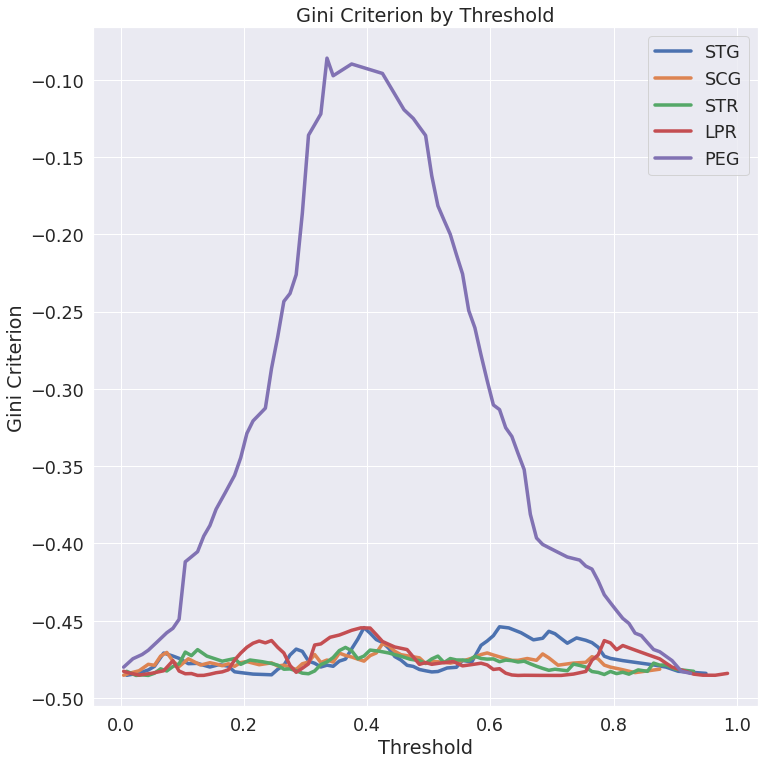

In [ ]:
sns.set(font_scale=1.6)
fig, ax = plt.subplots(figsize=(11, 11))
colors = []
for feature in features:
    thresholds, ginis, _, _ = find_best_split(np.array(data[feature]), np.array(data[target]))
    plot = ax.plot(thresholds, ginis, label=feature, linewidth=3.5)
    colors += [plot[0].get_color()]
    ax.set_title("Gini Criterion by Threshold")
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Gini Criterion")
plt.legend()
plt.tight_layout()

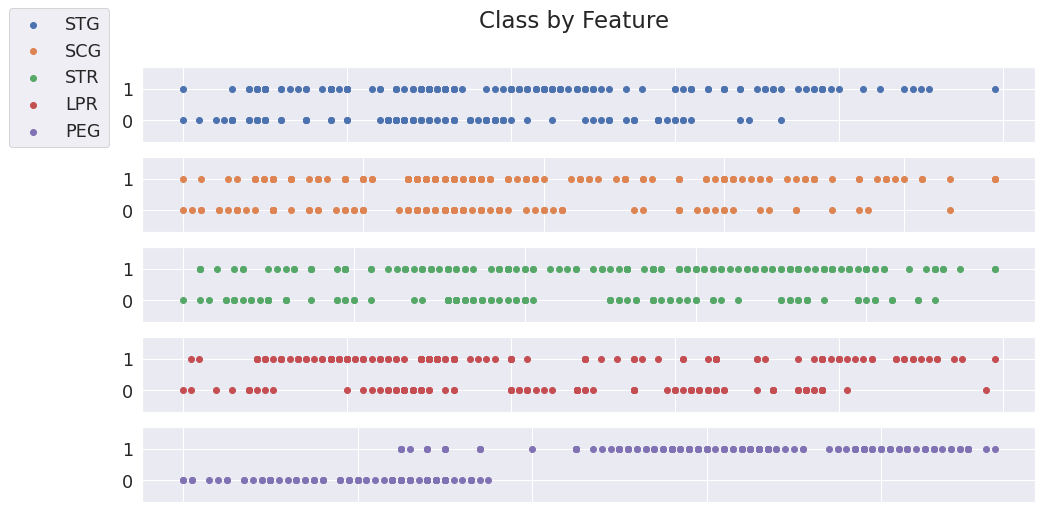

In [ ]:
sns.set(font_scale=1.6)
fig, axes = plt.subplots(5, 1, figsize=(16, 8))
fig.suptitle("Class by Feature")
for i, feature in enumerate(features):
    ax = axes[i]
    ax.scatter(data[feature], data[target], label=feature, color=colors[i])
    ax.set_ylim(-0.7, 1.7)
    ax.set_yticks([0, 1])
    ax.set_xticklabels([])
fig.legend(loc='upper left')

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** 
Признак `PEG` имеет кривую критерия Джини, которая ближе всего подходит к нулю. Это обусловлено тем, что если данные идеально разделимы по данному критерию, то критерий Джини достигает нуля на каком-то пороге. Эта разделимость признака `PEG` видна и по scatter-графику. Поэтому поделить данные по этому признаку будет очень хорошо. Если по признаку данные можно разделить идеально или почти идеально, то кривая критерия Джини будет на каком-то пороге достигать (или почти достигать) нуля. Наоборот, кривые критерия Джини для "плохих" признаков будут далеко от нуля.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw5code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

https://contest.yandex.ru/contest/43413/run-report/78532920/

In [6]:
class DecisionTree:
    def __init__(self, feature_types, max_depth=None, min_samples_split=None, min_samples_leaf=None):
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf

    def _fit_node(self, sub_X, sub_y, node):
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                counts = Counter(sub_X[:, feature])
                clicks = Counter(sub_X[sub_y == 1, feature])
                ratio = {}
                for key, current_count in counts.items():
                    if key in clicks:
                        current_click = clicks[key]
                    else:
                        current_click = 0
                    ratio[key] = current_click / current_count
                sorted_categories = list(map(lambda x: x[0], sorted(ratio.items(), key=lambda x: x[1])))
                categories_map = dict(zip(sorted_categories, list(range(len(sorted_categories)))))

                feature_vector = np.array(list(map(lambda x: categories_map[x], sub_X[:, feature])))
            else:
                raise ValueError

            if np.all(feature_vector == feature_vector[0]):
                continue

            _, _, threshold, gini = find_best_split(feature_vector, sub_y)
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini
                split = (feature_vector < threshold)

                if feature_type == "real":
                    threshold_best = threshold
                elif feature_type == "categorical":
                    threshold_best = list(map(lambda x: x[0],
                                              filter(lambda x: x[1] < threshold,
                                                     categories_map.items())))
                else:
                    raise ValueError

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["categories_split"] = threshold_best
        else:
            raise ValueError
        node["left_child"], node["right_child"] = {}, {}

        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x, node):
        if node["type"] == "terminal":
            return node["class"]
        elif node["type"] == "nonterminal":
            feature = node["feature_split"]
            feature_type = self._feature_types[feature]
            if feature_type == "real":
                if x[feature] < node["threshold"]:
                    return self._predict_node(x, node["left_child"])
                else:
                    return self._predict_node(x, node["right_child"])
            elif feature_type == "categorical":
                if x[feature] in node["categories_split"]:
                    return self._predict_node(x, node["left_child"])
                else:
                    return self._predict_node(x, node["right_child"])
            else:
                raise ValueError
        else:
            raise ValueError

    def fit(self, X, y):
        self._fit_node(X, y, self._tree)

    def predict(self, X):
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data 

In [13]:
mushrooms = pd.read_csv("agaricus-lepiota.data")

In [ ]:
mushrooms['p'] = mushrooms['p'].replace({'p': 1, 'e': 0})

In [ ]:
label_encoder = LabelEncoder()
target = 'p'
features = list(mushrooms.columns[1:])
for feature in features:
    mushrooms[feature] = label_encoder.fit_transform(mushrooms[feature])

In [35]:
def depth(tree):
    if isinstance(tree, dict):
        if tree != {}:
            return 1 + max(map(depth, tree.values()))
        else:
            return 0
    else:
        return 0

In [50]:
X, y = mushrooms[features], mushrooms[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69)
decision_tree = DecisionTree(['categorical'] * X_train.shape[1])
decision_tree.fit(np.array(X_train), np.array(y_train))
print(f"Train accuracy: {accuracy_score(y_train, decision_tree.predict(np.array(X_train))):.3f}")
print(f"Test  accuracy: {accuracy_score(y_test, decision_tree.predict(np.array(X_test))):.3f}")
print(f"Tree depth: {depth(decision_tree._tree)}")

Train accuracy: 1.000
Test  accuracy: 1.000
Tree depth: 9


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

In [172]:
class DecisionTree:
    def __init__(self, feature_types, max_depth=None, min_samples_split=None, min_samples_leaf=None):
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self._depth = 1

    def get_params(self, deep=False):
        return {'feature_types': self._feature_types, 
                'max_depth': self._max_depth, 
                'min_samples_split': self._min_samples_split, 
                'min_samples_leaf': self._min_samples_leaf
                }

    def _fit_node(self, sub_X, sub_y, node):
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                counts = Counter(sub_X[:, feature])
                clicks = Counter(sub_X[sub_y == 1, feature])
                ratio = {}
                for key, current_count in counts.items():
                    if key in clicks:
                        current_click = clicks[key]
                    else:
                        current_click = 0
                    ratio[key] = current_click / current_count
                sorted_categories = list(map(lambda x: x[0], sorted(ratio.items(), key=lambda x: x[1])))
                categories_map = dict(zip(sorted_categories, list(range(len(sorted_categories)))))

                feature_vector = np.array(list(map(lambda x: categories_map[x], sub_X[:, feature])))
            else:
                raise ValueError

            if np.all(feature_vector == feature_vector[0]):
                continue

            _, _, threshold, gini = find_best_split(feature_vector, sub_y)
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini
                split = (feature_vector < threshold)

                if feature_type == "real":
                    threshold_best = threshold
                elif feature_type == "categorical":
                    threshold_best = list(map(lambda x: x[0],
                                              filter(lambda x: x[1] < threshold,
                                                     categories_map.items())))
                else:
                    raise ValueError

        if (feature_best is None) or \
                (self._max_depth is not None and self._depth == self._max_depth) or \
                (self._min_samples_split is not None and len(sub_y) < self._min_samples_split) or \
                (self._min_samples_leaf is not None and len(sub_y[split]) < self._min_samples_leaf) or \
                (self._min_samples_leaf is not None and len(sub_y[np.logical_not(split)]) < self._min_samples_leaf):
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["categories_split"] = threshold_best
        else:
            raise ValueError
        node["left_child"], node["right_child"] = {}, {}
        self._depth += 1
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x, node):
        if node["type"] == "terminal":
            return node["class"]
        elif node["type"] == "nonterminal":
            feature = node["feature_split"]
            feature_type = self._feature_types[feature]
            if feature_type == "real":
                if x[feature] < node["threshold"]:
                    return self._predict_node(x, node["left_child"])
                else:
                    return self._predict_node(x, node["right_child"])
            elif feature_type == "categorical":
                if x[feature] in node["categories_split"]:
                    return self._predict_node(x, node["left_child"])
                else:
                    return self._predict_node(x, node["right_child"])
            else:
                raise ValueError
        else:
            raise ValueError

    def fit(self, X, y):
        self._fit_node(X, y, self._tree)

    def predict(self, X):
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)


In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data

In [131]:
tictactoe = pd.read_csv("tic-tac-toe.data")

In [132]:
label_encoder = LabelEncoder()
target = 'positive'
features = list(tictactoe.columns[:-1])
tictactoe[target] = tictactoe[target].replace({'positive': 1, 'negative': 0})
for feature in features:
    tictactoe[feature] = label_encoder.fit_transform(tictactoe[feature])

In [140]:
max_depth_s = np.arange(1, 50 + 1, 1)
min_samples_split_s = np.arange(2, 10 + 1, 1)
min_samples_leaf_s = np.arange(1, 8 + 1, 1)

X, y = tictactoe[features], tictactoe[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=69, stratify=y)
feature_types = ['categorical'] * X_train.shape[1]

X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

max_depth_accuracies_train = []
max_depth_accuracies_test = []

for max_depth in max_depth_s:
    decision_tree = DecisionTree(feature_types, max_depth=max_depth)
    decision_tree.fit(X_train, y_train)
    max_depth_accuracies_train += [accuracy_score(y_train, decision_tree.predict(X_train))]
    max_depth_accuracies_test += [accuracy_score(y_test, decision_tree.predict(X_test))]

min_samples_split_accuracies_train = []
min_samples_split_accuracies_test = []

for min_samples_split in min_samples_split_s:
    decision_tree = DecisionTree(feature_types, min_samples_split=min_samples_split)
    decision_tree.fit(X_train, y_train)
    min_samples_split_accuracies_train += [accuracy_score(y_train, decision_tree.predict(X_train))]
    min_samples_split_accuracies_test += [accuracy_score(y_test, decision_tree.predict(X_test))]

min_samples_leaf_accuracies_train = []
min_samples_leaf_accuracies_test = []

for min_samples_leaf in min_samples_leaf_s:
    decision_tree = DecisionTree(feature_types, min_samples_leaf=min_samples_leaf)
    decision_tree.fit(X_train, y_train)
    min_samples_leaf_accuracies_train += [accuracy_score(y_train, decision_tree.predict(X_train))]
    min_samples_leaf_accuracies_test += [accuracy_score(y_test, decision_tree.predict(X_test))]

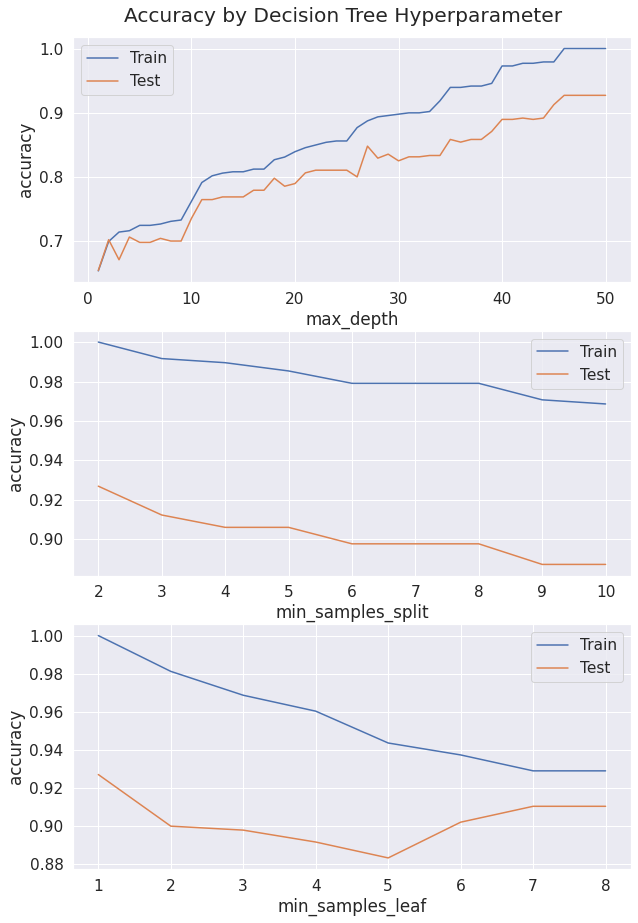

In [153]:
sns.set(font_scale=1.4)
fig, axes = plt.subplots(3, 1, figsize=(10, 14))
fig.suptitle("Accuracy by Decision Tree Hyperparameter")
plt.subplots_adjust(top=0.95)

ax = axes[0]
ax.plot(max_depth_s, max_depth_accuracies_train, label="Train")
ax.plot(max_depth_s, max_depth_accuracies_test, label="Test")
ax.set_xlabel("max_depth")
ax.set_ylabel("accuracy")
ax.legend()

ax = axes[1]
ax.plot(min_samples_split_s, min_samples_split_accuracies_train, label="Train")
ax.plot(min_samples_split_s, min_samples_split_accuracies_test, label="Test")
ax.set_xlabel("min_samples_split")
ax.set_ylabel("accuracy")
ax.legend()

ax = axes[2]
ax.plot(min_samples_leaf_s, min_samples_leaf_accuracies_train, label="Train")
ax.plot(min_samples_leaf_s, min_samples_leaf_accuracies_test, label="Test")
ax.set_xlabel("min_samples_leaf")
ax.set_ylabel("accuracy")
ax.legend()

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data

In [97]:
accuracy_scorer = make_scorer(accuracy_score)

In [215]:
mushrooms = pd.read_csv("agaricus-lepiota.data")
tictactoe = pd.read_csv("tic-tac-toe.data")
cars = pd.read_csv("car.data")
nursery = pd.read_csv("nursery.data")

In [216]:
mushrooms['p'] = mushrooms['p'].replace({'p': 1, 'e': 0})
tictactoe['positive'] = tictactoe['positive'].replace({'positive': 1, 'negative': 0})
cars['unacc'] = cars['unacc'].replace({'unacc': 0, 'acc': 0, 'vgood': 1, 'good': 1})
nursery['recommend'] = nursery['recommend'].replace({'not_recom': 0, 'recommend': 0, 'very_recom': 1, 'priority': 1, 'spec_prior': 1})

In [217]:
accuracies = pd.DataFrame(index=np.arange(4), columns=['Dataset', 'DecisionTree_real', 'DecisionTree_categorical', 'DecisionTree_real_one_hot', 'DecisionTreeClassifier'])
accuracies['Dataset'] = pd.Series(['mushrooms', 'tictactoe', 'cars', 'nursery'])

datasets = [mushrooms, tictactoe, cars, nursery]
targets = ['p', 'positive', 'unacc', 'recommend']
features_list = [mushrooms.columns[1:], tictactoe.columns[:-1], cars.columns[:-1], nursery.columns[:-1]]

label_encoder = LabelEncoder()
for i in range(4):
    data = datasets[i]
    features = features_list[i]
    for feature in features:
        data[feature] = label_encoder.fit_transform(data[feature])

In [191]:
for i in range(4):
    data = datasets[i]
    target = targets[i]
    features = features_list[i]
    X = np.array(data[features])
    y = np.array(data[target])
    decision_tree = DecisionTree(['real'] * X.shape[1])
    accuracies['DecisionTree_real'][i] = np.around(np.mean(cross_val_score(decision_tree, X, y, scoring=accuracy_scorer, cv=10)), decimals=3)
    decision_tree = DecisionTree(['categorical'] * X.shape[1])
    accuracies['DecisionTree_categorical'][i] = np.around(np.mean(cross_val_score(decision_tree, X, y, scoring=accuracy_scorer, cv=10)), decimals=3)
    X_ohe = OneHotEncoder(sparse=False).fit_transform(X)
    decision_tree = DecisionTree(['real'] * X_ohe.shape[1])
    accuracies['DecisionTree_real_one_hot'][i] = np.around(np.mean(cross_val_score(decision_tree, X_ohe, y, scoring=accuracy_scorer, cv=10)), decimals=3)
    decision_tree = DecisionTreeClassifier()
    accuracies['DecisionTreeClassifier'][i] = np.around(np.mean(cross_val_score(decision_tree, X, y, scoring=accuracy_scorer, cv=10)), decimals=3)

In [207]:
accuracies

,Dataset,DecisionTree_real,DecisionTree_categorical,DecisionTree_real_one_hot,DecisionTreeClassifier
0,mushrooms,0.999,1.0,1.0,0.963
1,tictactoe,0.463,0.549,0.554,0.786
2,cars,0.943,0.968,0.922,0.945
3,nursery,1.0,1.0,1.0,1.0


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:** Нет, не одинаково. На `mushrooms` кастомное дерево обучается идеально все три раза, а `sklearn`-овское недообучается. На `nursery` все модели обучаются идеально. На `cars` считать признаки категориальными выгоднее (что логично), и даже лучше чем `sklearn`-овским деревом. На `tictactoe` все модели очень плохо учатся (относительно других датасетов), но `sklearn`-овское дерево обучается лучше кастомных.

Это можно объяснить количеством различных значений признаков в датасетах. Посмотрим:

In [231]:
mushrooms.nunique()

p       2
x       6
s       4
n      10
t       2
p.1     9
f       2
c       2
n.1     2
k      12
e       2
e.1     5
s.1     4
s.2     4
w       9
w.1     9
p.2     1
w.2     4
o       3
p.3     5
k.1     9
s.3     6
u       7
dtype: int64

In [232]:
tictactoe.nunique()

x           3
x.1         3
x.2         3
x.3         3
o           3
o.1         3
x.4         3
o.2         3
o.3         3
positive    2
dtype: int64

In [233]:
cars.nunique()

vhigh      4
vhigh.1    4
2          4
2.1        3
small      3
low        3
unacc      2
dtype: int64

In [234]:
nursery.nunique()

usual           3
proper          5
complete        4
1               4
convenient      3
convenient.1    2
nonprob         3
recommended     3
recommend       2
dtype: int64

Чем больше различных значений, тем больше шанс, что признак окажется информативным при делении на поддеревья. В `tictactoe` просто мало различных значений, чтобы деревья хорошо работали.

Опционально можно также посмотреть на кривые критерия Джини для этих датасетов. Для этого надо немного изменить функцию `find_best_split`.

In [223]:
def find_best_split(feature_vector: np.array, target_vector: np.array):
    index_sort = np.argsort(feature_vector)
    feature_vector_sorted = feature_vector[index_sort]
    target_vector_sorted = target_vector[index_sort]
    feature_vector_unique = np.unique(feature_vector_sorted)
    thresholds = (feature_vector_unique[1:] + feature_vector_unique[:-1]) / 2

    size = len(feature_vector)
    left_subtree_size = np.arange(1, size, 1)
    right_subtree_size = size - left_subtree_size

    left_subtree_positive_size = np.cumsum(target_vector_sorted)
    positive_size = left_subtree_positive_size[-1]
    left_subtree_positive_size = left_subtree_positive_size[:-1]
    right_subtree_positive_size = positive_size - left_subtree_positive_size

    left_subtree_positive_probability = left_subtree_positive_size / left_subtree_size
    left_subtree_negative_probability = 1 - left_subtree_positive_probability
    right_subtree_positive_probability = right_subtree_positive_size / right_subtree_size
    right_subtree_negative_probability = 1 - right_subtree_positive_probability

    ginis = - (left_subtree_size / size) * (1 - left_subtree_positive_probability ** 2 - left_subtree_negative_probability ** 2) \
            - (right_subtree_size / size) * (1 - right_subtree_positive_probability ** 2 - right_subtree_negative_probability ** 2)
    ginis = ginis[feature_vector_sorted[1:] != feature_vector_sorted[:-1]]
    if len(ginis) > 0:
        best_index = np.argmax(ginis)
        threshold_best = thresholds[best_index]
        gini_best = ginis[best_index]
    else:
        best_index = 0
        threshold_best = target_vector_sorted[0]
        gini_best = -1

    return thresholds, ginis, threshold_best, gini_best

In [239]:
names = ['mushrooms', 'tictactoe', 'cars', 'nursery']

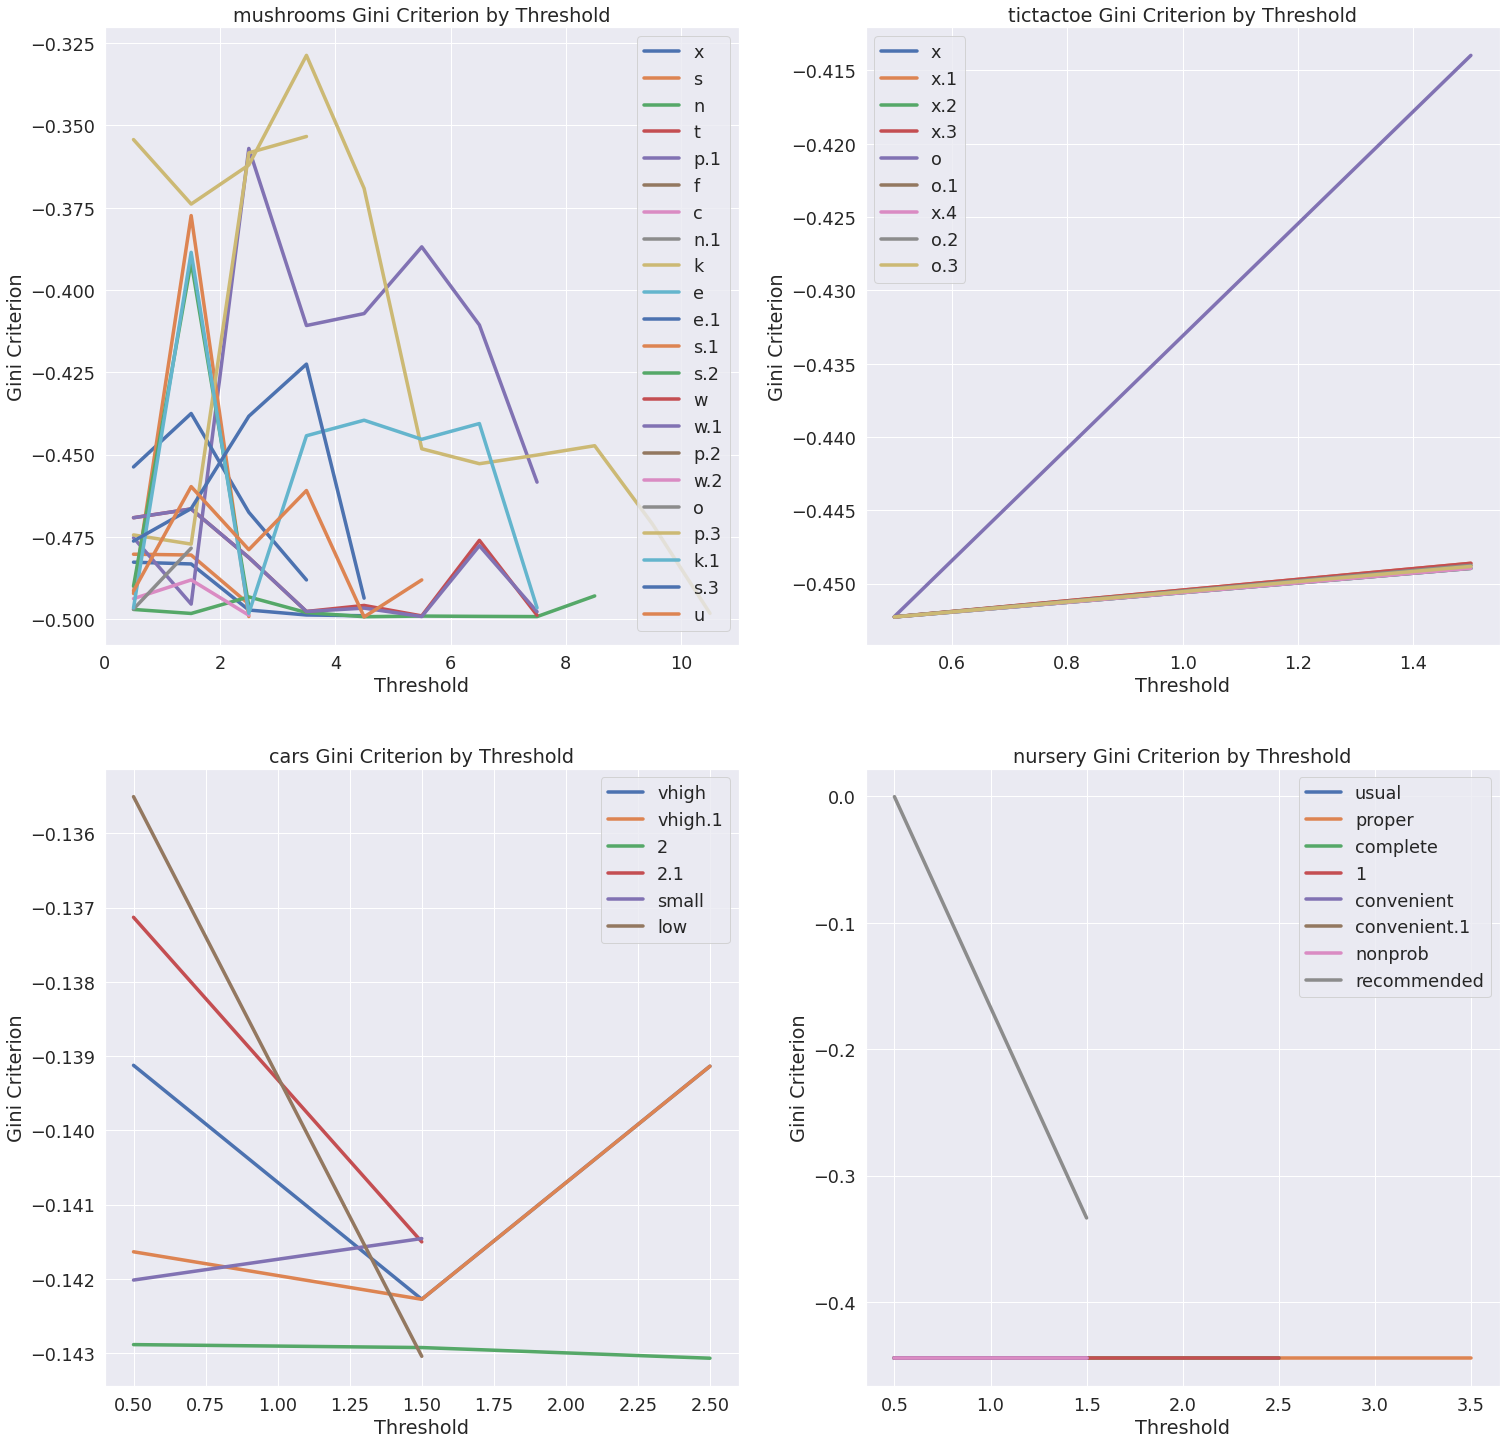

In [240]:
sns.set(font_scale=1.6)
fig, axes = plt.subplots(2, 2, figsize=(25, 25))
for i in range(4):
    ax = axes[i // 2, i % 2]
    data = datasets[i]
    target = targets[i]
    features = features_list[i]
    for feature in features:
        thresholds, ginis, _, _ = find_best_split(np.array(data[feature]), np.array(data[target]))
        ax.plot(thresholds, ginis, label=feature, linewidth=3.5)
        ax.set_title(f"{names[i]} Gini Criterion by Threshold")
        ax.set_xlabel("Threshold")
        ax.set_ylabel("Gini Criterion")
    ax.legend()
# plt.legend()
# plt.tight_layout()

Конечно, они выглядят убого, но тут заметно, что кривая для `tictactoe` находится дальше всего от нуля, а для `cars` и `nursery` довольно близка к нулю. Также тут видно, насколько разнообразны критерии у `mushrooms` и `cars`. Наконец, признак `recommended` и таргет `recommend` в `nursery` вообще совпадают в 2/3 случаев:

In [241]:
np.sum(nursery['recommended'] == nursery['recommend']) / nursery.shape[0]

0.6667181109653523

Это помогает моделям так хорошо обучаться.

-------------------------------

Вставьте что угодно, описывающее ваши впечатления от этого задания:

Хотелось бы передать составителю задания, что код в `hw5code.py` абсолютно нечитабельный. Нет комментариев, что делают методы класса `DecisionTree`, нет объяснений, что значат параметры и переменные, и не всегда понятно по их названиям, а однобуквенные названия и выражения типа `for x in X` не способствуют пониманию и читабельности.

Также в задании не было сказано, что для того чтобы `DecisionTree` работал с `cross_val_score`, в нём нужно реализовать метод `get_params`. 